In [2]:
from result_storing_utils import get_data, retrieve_ess_data, get_cyc_model, get_normal_model
import numpy as np 
import math
import matplotlib.pyplot as plt 

In [3]:
def rolling(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

Text(0.5, 1.0, 'Moving Averages of Acceptance Rate for DMALA')

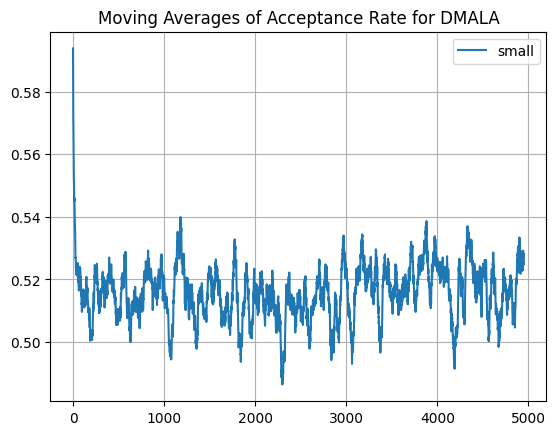

In [4]:
dmala_small = get_normal_model('dmala', .2)
# dmala_mid = get_normal_model('dmala', .5)
# dmala_big = get_normal_model('dmala', 1.0)

dmala_small_a_s = get_data('figs/rbm_sample', dmala_small, "a_s")
# dmala_mid_a_s = get_data('figs/ising_sample', dmala_mid, "a_s")
# dmala_big_a_s = get_data('figs/ising_sample', dmala_big, "a_s")

window = 50
plt.plot(rolling(dmala_small_a_s, window), label='small')
# plt.plot(rolling(dmala_mid_a_s, window), label='mid')
# plt.plot(rolling(dmala_big_a_s, window), label='big')
plt.grid()
plt.legend()
plt.title("Moving Averages of Acceptance Rate for DMALA")

In [5]:
step_size = [.5, 1.0, 1.5, 2.0]
init_bal = [.7, .8, .9, 1.0]
num_cycles = [100, 500]
dmala_cyc = get_cyc_model('cyc_dmala', num_cycles[0],
                         step_size[0], 
                         True, 
                         init_bal[1],
                         True, 
                         False)
dmala = get_normal_model('dmala', .2)

a_s_cyc = get_data('figs/rbm_sample', dmala_cyc, 'a_s')
a_s_normal = get_data('figs/rbm_sample', dmala, 'a_s')
log_mmds_normal = get_data('figs/rbm_sample', dmala, 'log_mmds')

In [6]:
a_s_dct = {}
log_mmds_dct = {}
for s in step_size: 
    for b in init_bal: 
        for c in num_cycles: 
            k = f'step_{s}_bal_{b}_cycles_{c}'
            dmala_cyc = get_cyc_model('cyc_dmala', c,
                         s, 
                         True, 
                         b,
                         True, 
                         False)
            a_s = get_data('figs/rbm_sample', dmala_cyc, 'a_s')
            a_s_dct[k] = a_s
            mmds = get_data('figs/rbm_sample', dmala_cyc, 'log_mmds')
            log_mmds_dct[k] = mmds

In [7]:
def calc_stepsizes(init_stepsize, total_iter):
    res = []
    for k_iter in range(total_iter):
        inner = (np.pi * k_iter)/total_iter
        cur_step_size = init_stepsize * (np.cos(inner) + 1)
        step_size = cur_step_size
        res.append(step_size)
    return np.array(res)


def calc_balancing_constants(init_bal, total_iter):
    res = []
    for k_iter in range(total_iter):
        inner = (np.pi * k_iter) / total_iter
        cur_balancing_constant = (init_bal - .5) / 2 * (np.cos(inner)) + (
                    init_bal + .5) / 2
        res.append(cur_balancing_constant)
    return np.array(res)


def get_dct_key(step, bal, cyc): 
    k = f'step_{step}_bal_{bal}_cycles_{cyc}'
    return k

In [8]:
# step 1.0, bal .9, cyc 100 has same behavior as step 2.0, bal 1.0, cyc 100

step = .5
bal = 1.0
cyc = 100
k = get_dct_key(step, bal, cyc)

a_s_cyc = a_s_dct[k]
mmds_cyc = log_mmds_dct[k]
k_loop = 10
total_iter = math.ceil(5000 / cyc)
cyc_a_s_dct = {}
# getting average a_s for cycle
steps = calc_stepsizes(step, total_iter)
for b in [.7, 1.0]: 
    for s in [.5, 2.0]:
        k = get_dct_key(s, b, cyc)
        a_s_cyc = a_s_dct[k]
        a_s_cyc_avg = np.zeros((cyc, total_iter))
        a_s_normal_avg = np.zeros((cyc, total_iter))
        for k_loop in range(cyc):
            a_s_cyc_avg[k_loop, :]  = a_s_cyc[k_loop * total_iter: (k_loop+1) * total_iter]
            a_s_normal_avg[k_loop, :] = a_s_normal[k_loop * total_iter: (k_loop+1) * total_iter]
        cyc_a_s_dct[f'{s}_{b}'] = a_s_cyc_avg


    

In [9]:
# what things would i be interested in, given acceptance rate for large step size 
# what was the acceptance rate like during the cycle with the largest decrease in MMDs? 
# what about on average? 
# what about the largest increase? 


Text(0, 0.5, 'Acceptance Rate')

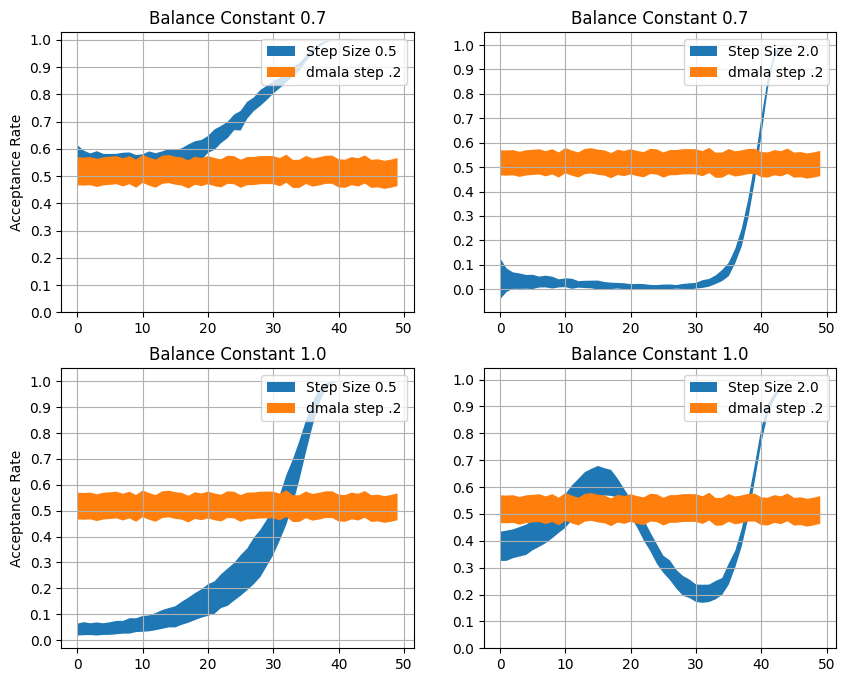

In [10]:
avg_range = (0, 100)
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
x = [i for i in range(50)]
for j, b in enumerate([.7, 1.0]):
    for i, s in enumerate([.5, 2.0]): 
        a_s_cyc_avg = cyc_a_s_dct[f'{s}_{b}']
        a_s_cyc_toplot = a_s_cyc_avg[avg_range[0]:avg_range[1] , :].mean(axis=0)
        a_s_normal_toplot = a_s_normal_avg[avg_range[0]:avg_range[1] , :].mean(axis=0)

        a_s_cyc_upper = a_s_cyc_toplot + a_s_cyc_avg[avg_range[0]:avg_range[1] , :].std(axis=0)
        a_s_cyc_lower = a_s_cyc_toplot - a_s_cyc_avg[avg_range[0]:avg_range[1] , :].std(axis=0)

        a_s_normal_upper = a_s_normal_toplot + a_s_normal.std(axis=0)
        a_s_normal_lower = a_s_normal_toplot - a_s_normal.std(axis=0)

        total_iter = math.ceil(5000 / cyc)

        ax[j, i].fill_between(x, a_s_cyc_lower, a_s_cyc_upper, label=f"Step Size {s}")
        ax[j, i].fill_between(x, a_s_normal_lower, a_s_normal_upper, label="dmala step .2")


        ax[j, i].legend()
        ax[j, i].set_title(f"Balance Constant {b}")
        ax[j, i].grid()

ax[0, 0].set_yticks([.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])
ax[0, 1].set_yticks([.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])
ax[1, 0].set_yticks([.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])
ax[1, 1].set_yticks([.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])
ax[1, 0].set_ylabel('Acceptance Rate')
ax[0, 0].set_ylabel('Acceptance Rate')

Text(0, 0.5, 'Acceptance Rate')

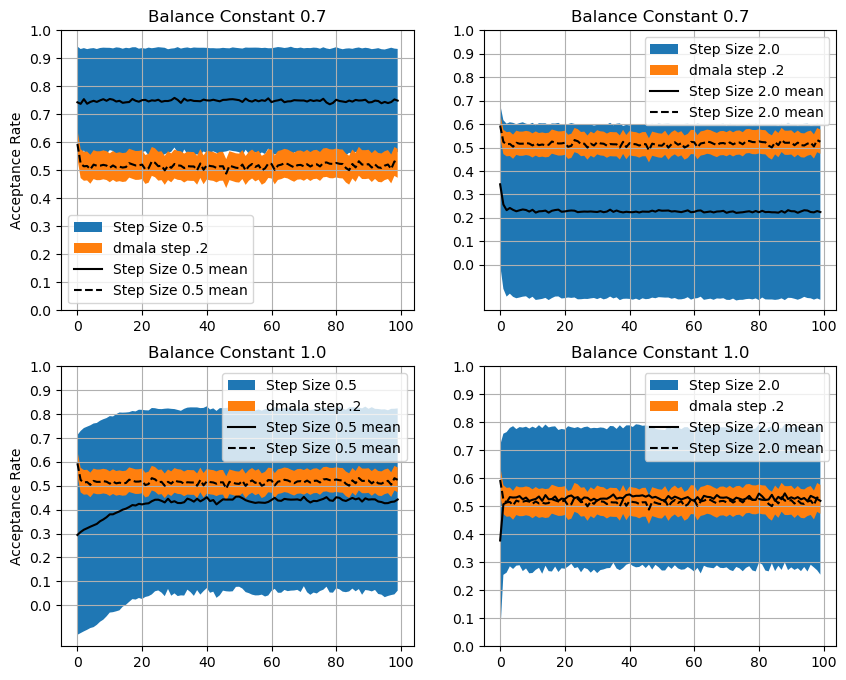

In [10]:
avg_range = (0, 100)
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
x = [i for i in range(100)]
for j, b in enumerate([.7, 1.0]):
    for i, s in enumerate([.5, 2.0]): 
        a_s_cyc_avg = cyc_a_s_dct[f'{s}_{b}']
        a_s_cyc_toplot = a_s_cyc_avg[avg_range[0]:avg_range[1] , :].mean(axis=1)
        a_s_normal_toplot = a_s_normal_avg[avg_range[0]:avg_range[1] , :].mean(axis=1)

        a_s_cyc_upper = a_s_cyc_toplot + a_s_cyc_avg[avg_range[0]:avg_range[1] , :].std(axis=1)
        a_s_cyc_lower = a_s_cyc_toplot - a_s_cyc_avg[avg_range[0]:avg_range[1] , :].std(axis=1)

        a_s_normal_upper = a_s_normal_toplot + a_s_normal.std(axis=0)
        a_s_normal_lower = a_s_normal_toplot - a_s_normal.std(axis=0)

        total_iter = math.ceil(5000 / cyc)

        ax[j, i].fill_between(x, a_s_cyc_lower, a_s_cyc_upper, label=f"Step Size {s}")
        ax[j, i].fill_between(x, a_s_normal_lower, a_s_normal_upper, label="dmala step .2")
        ax[j, i].plot(x, a_s_cyc_toplot, label=f"Step Size {s} mean", color='black')
        ax[j, i].plot(x, a_s_normal_toplot, '--', label=f"Step Size {s} mean", color='black')

        ax[j, i].legend()
        ax[j, i].set_title(f"Balance Constant {b}")
        ax[j, i].grid()

ax[0, 0].set_yticks([.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])
ax[0, 1].set_yticks([.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])
ax[1, 0].set_yticks([.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])
ax[1, 1].set_yticks([.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])
ax[1, 0].set_ylabel('Acceptance Rate')
ax[0, 0].set_ylabel('Acceptance Rate')

In [11]:
# step 1.0, bal .9, cyc 100 has same behavior as step 2.0, bal 1.0, cyc 100

step = 2.0
bal = 1.0
cyc = 100
base_dir_rbm = 'figs/rbm_sample'
log_mmds_cyc_dula = get_data(base_dir_rbm, 
                                get_cyc_model('cyc_dula', 500, 2.0, True, 1.0, True, False), 'log_mmds')
log_mmds_dula = get_data(base_dir_rbm, 
                                get_normal_model('dula', .2), 'log_mmds')
total_iter = math.ceil(5000 / cyc)

# getting average a_s for cycle
steps = calc_stepsizes(step, total_iter)
log_mmds_cyc_avg = np.zeros((cyc, total_iter // 10))
log_mmds_normal_avg = np.zeros((cyc, total_iter // 10))


for k_loop in range(cyc): 
    init_val_cyc_dula = log_mmds_cyc_dula[int(k_loop * total_iter // 10)]
    data_cyc =  log_mmds_cyc_dula[int(k_loop * total_iter // 10) : int((k_loop + 1) * (total_iter) // 10)]
    log_mmds_cyc_avg[k_loop, :] = 100 * (data_cyc - init_val_cyc_dula) / init_val_cyc_dula
    
    init_val_normal_dula = log_mmds_dula[int(k_loop * total_iter // 10)]
    data_normal =  log_mmds_dula[int(k_loop * total_iter // 10) : int((k_loop + 1) * (total_iter) // 10)]
    log_mmds_normal_avg[k_loop, :] = 100 * (data_normal - init_val_normal_dula) / init_val_normal_dula

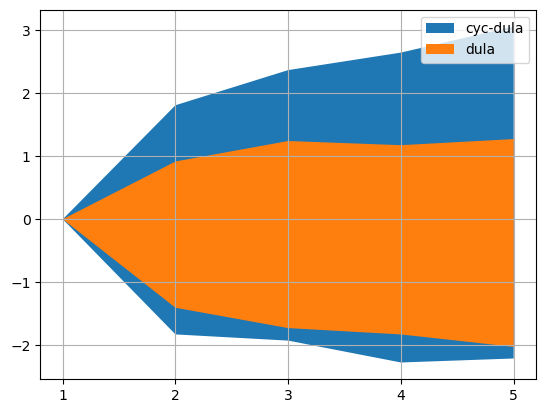

In [12]:
above = log_mmds_cyc_avg.mean(axis=0) + log_mmds_cyc_avg.std(axis=0)
below = log_mmds_cyc_avg.mean(axis=0) - log_mmds_cyc_avg.std(axis=0)
plt.fill_between(range(1, 6), below, above, label='cyc-dula') 

above = log_mmds_normal_avg.mean(axis=0) + log_mmds_normal_avg.std(axis=0)
below = log_mmds_normal_avg.mean(axis=0) - log_mmds_normal_avg.std(axis=0)
plt.fill_between(range(1, 6), below, above, label='dula') 
plt.grid()
plt.xticks([1, 2, 3, 4, 5])
plt.legend()

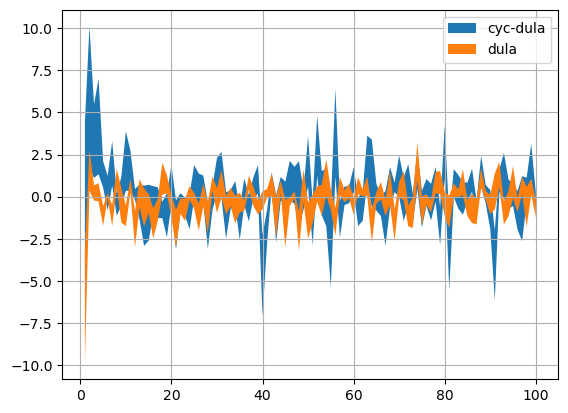

In [13]:
above = log_mmds_cyc_avg.mean(axis=1) + log_mmds_cyc_avg.std(axis=1)
below = log_mmds_cyc_avg.mean(axis=1) - log_mmds_cyc_avg.std(axis=1)
plt.fill_between(range(1, 101), below, above, label='cyc-dula') 

above = log_mmds_normal_avg.mean(axis=1) + log_mmds_normal_avg.std(axis=1)
below = log_mmds_normal_avg.mean(axis=1) - log_mmds_normal_avg.std(axis=1)
plt.fill_between(range(1, 101), below, above, label='dula') 
plt.grid()
plt.legend()

In [14]:
dula_cyc_adapt_good = get_cyc_model('cyc_dula', 250,
                         2.0, 
                         True, 
                         1.0,
                         True, 
                         False,
                         True, .05, 'simple_cycle', 'step')
dula_cyc_adapt_bad = get_cyc_model('cyc_dula', 250,
                         1.5, 
                         True, 
                         1.0,
                         True, 
                         False,
                         True, .05, 'simple_cycle', 'step')
dula_cyc = get_cyc_model('cyc_dula', 250,
                         2.0, 
                         True, 
                         1.0,
                         True, 
                         False,
                         False, .05)
dula_cyc_bad = get_cyc_model('cyc_dula', 250,
                         1.5, 
                         True, 
                         1.0,
                         True, 
                         False,
                         False, .01)

dmala = get_normal_model('dmala', .2)
log_mmds_cyc_adapt_good = get_data('figs/rbm_sample', dula_cyc_adapt_good, 'log_mmds')
log_mmds_cyc_adapt_bad = get_data('figs/rbm_sample', dula_cyc_adapt_bad, 'log_mmds')

log_mmds_cyc = get_data('figs/rbm_sample', dula_cyc, 'log_mmds')
log_mmds_cyc_bad = get_data('figs/rbm_sample', dula_cyc_bad, 'log_mmds')

log_mmds_baseline = get_data('figs/rbm_sample', dmala, 'log_mmds')

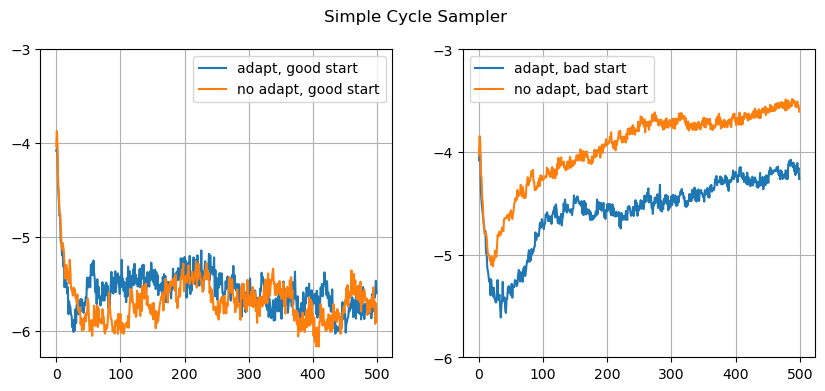

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(log_mmds_cyc_adapt_good, label="adapt, good start")
ax[0].plot(log_mmds_cyc, label="no adapt, good start")
ax[0].legend()
ax[0].set_yticks([-6, -5, -4, -3])
ax[0].grid()
ax[1].plot(log_mmds_cyc_adapt_bad, label="adapt, bad start")
ax[1].plot(log_mmds_cyc_bad, label="no adapt, bad start")
ax[1].set_yticks([-6, -5, -4, -3])

plt.suptitle("Simple Cycle Sampler")
plt.legend()
plt.grid()


In [16]:
dula_cyc_adapt_opt = get_cyc_model('cyc_dula', 250,
                         2.0,
                         True, 
                         1.0,
                         True,
                         False, True, .05, 'simple_cycle', 'step')
dula_cyc_adapt_worse = get_cyc_model('cyc_dula', 250,
                         1.5,
                         True, 
                         1.0,
                         True,
                         False, True, .05, 'simple_cycle', 'step')
dula_cyc_adapt_worst = get_cyc_model('cyc_dula', 250,
                         1.0,
                         True, 
                         1.0,
                         True,
                         False, True, .05, 'simple_cycle', 'step')

cyc_as_opt = get_data('figs/rbm_sample', dula_cyc_adapt_opt, 'a_s_burnin_target_0.2')
cyc_as_worse = get_data('figs/rbm_sample', dula_cyc_adapt_worse, 'a_s_burnin_target_0.2')
cyc_as_worst = get_data('figs/rbm_sample', dula_cyc_adapt_worst, 'a_s_burnin_target_0.2')

# cyc_as = get_data('figs/rbm_sample', dula_cyc_adapt, 'burnin_hops')

cyc_steps_opt = get_data('figs/rbm_sample', dula_cyc_adapt_opt, 'steps_burnin')
cyc_steps_worse = get_data('figs/rbm_sample', dula_cyc_adapt_worse, 'steps_burnin')
cyc_steps_worst = get_data('figs/rbm_sample', dula_cyc_adapt_worst, 'steps_burnin')

Text(0.5, 1.0, 'Expected Flips (Rolling Mean)')

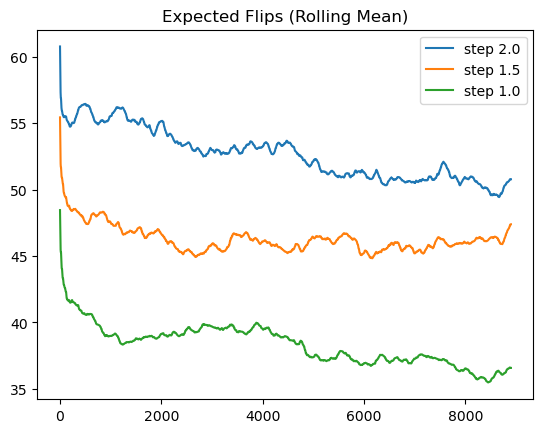

In [17]:

flip_probs_opt = get_data('figs/rbm_sample', dula_cyc_adapt_opt, 'burn_in_flip_probs')
flip_probs_worse = get_data('figs/rbm_sample', dula_cyc_adapt_worse, 'burn_in_flip_probs')
flip_probs_worst = get_data('figs/rbm_sample', dula_cyc_adapt_worst, 'burn_in_flip_probs')

plt.plot(rolling(flip_probs_opt, 100), label = 'step 2.0')
plt.plot(rolling(flip_probs_worse, 100), label = 'step 1.5')
plt.plot(rolling(flip_probs_worst, 100), label = 'step 1.0')
plt.legend()
plt.title("Expected Flips (Rolling Mean)")

Text(0.5, 1.0, 'Average Acc Rate (Rolling Mean)')

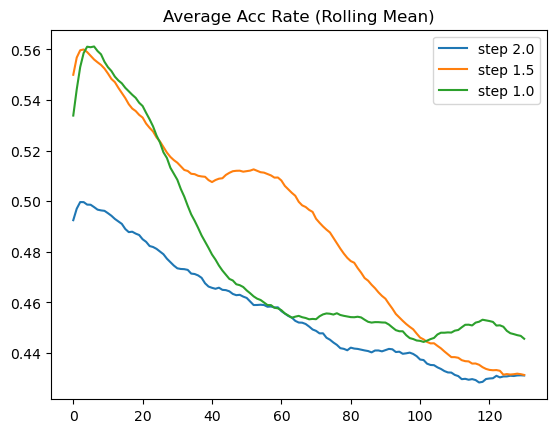

In [18]:
plt.plot(rolling(cyc_as_opt, 20), label = 'step 2.0')
plt.plot(rolling(cyc_as_worse, 20), label = 'step 1.5')
plt.plot(rolling(cyc_as_worst, 20), label = 'step 1.0')
plt.legend()

plt.title("Average Acc Rate (Rolling Mean)")

Text(0.5, 1.0, 'Step Size Movement')

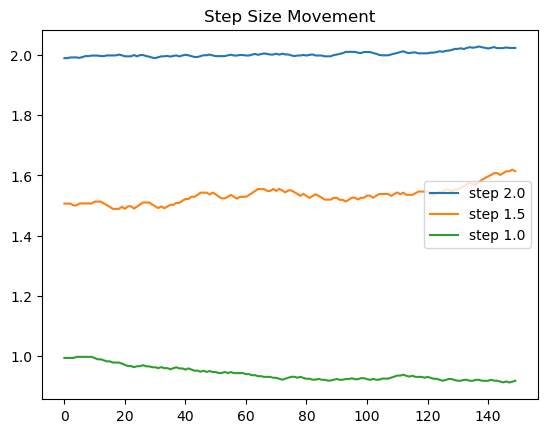

In [19]:
plt.plot(cyc_steps_opt, label = 'step 2.0')
plt.plot(cyc_steps_worse, label = 'step 1.5')
plt.plot(cyc_steps_worst, label = 'step 1.0')
plt.legend()

plt.title("Step Size Movement")

In [44]:
# Code for looking at acceptance rate for different step sizes of DMALA (constant)

def get_dmala(step_size, bal, metric): 
    return np.load(f"figs/rbm_sample/dmala_stepsize_{step_size}_{bal}_{metric}.npy", allow_pickle=True)


In [247]:
get_dmala(2.5, .9, "a_s").mean()

c = [.5, .6, .8, 1.0, 1.2, 1.5, 1.7, 2.0, 2.2, 2.5]
bal_small = [.6, .7, .8, .9, 1.0]
best_acc_array = []

best_bal_small = []
best_acc_small = []
for s in step_sizes_small: 
    
    # figure out the best acceptance rate
    
    accs = [get_dmala(s, b, "a_s").mean() for b in bal_small]
    best_idx = np.argmax(accs)
    best_bal_small.append(bal[best_idx])
    best_acc_small.append(accs[best_idx])
    best_acc_array.append(get_dmala(s, bal_small[best_idx], "a_s"))

    
step_sizes_big = [3.0, 3.2, 4.0, 4.2, 4.5, 4.7, 5.0, 5.5, 6.0, 7.0, 8.0, 9.0, 10.0]
bal_big = [.9, .92, .95, .97, .99, 1.0]

best_bal_big = []
best_acc_big = []
for s in step_sizes_big: 
    
    # figure out the best acceptance rate
    
    accs = [get_dmala(s, b, "a_s").mean() for b in bal_big]
    best_idx = np.argmax(accs)
    best_bal_big.append(bal_big[best_idx])
    best_acc_big.append(get_dmala(s, bal_big[best_idx], "a_s").mean())
    best_acc_array.append(get_dmala(s, bal_big[best_idx], "a_s"))


In [ ]:
steps = step_sizes_small + step_sizes_big 
to_plot_steps = [.5, 1.0, 2.5, 4.0, 5.0, 8.0, 10.0]
cut_off_idx = 100
to_plot_arrays = []
for i, s in enumerate(steps):
    if s in to_plot_steps: 
        to_plot_arrays.append(best_acc_array[i])
        
for i, a_s in enumerate(to_plot_arrays):
    plt.plot(rolling(a_s[:cut_off_idx], 10), label=f"{to_plot_steps[i]} step")
use_big = np.load(f"figs/rbm_sample/dmala_use_big_a_s.npy", allow_pickle=True)
plt.plot(rolling(use_big[:cut_off_idx], 10), label="use big")
plt.grid()
plt.title("First 100 steps bDMALA rbm")
plt.legend()

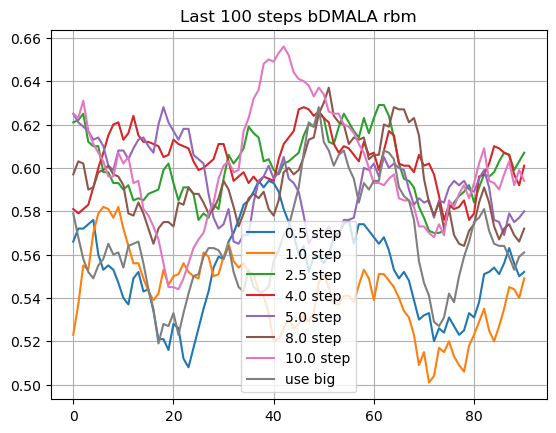

In [259]:
steps = step_sizes_small + step_sizes_big 
to_plot_steps = [.5, 1.0, 2.5, 4.0, 5.0, 8.0, 10.0]
cut_off_idx = 100
to_plot_arrays = []
for i, s in enumerate(steps):
    if s in to_plot_steps: 
        to_plot_arrays.append(best_acc_array[i])
        
for i, a_s in enumerate(to_plot_arrays):
    plt.plot(rolling(a_s[-cut_off_idx:], 10), label=f"{to_plot_steps[i]} step")
use_big = np.load(f"figs/rbm_sample/dmala_use_big_a_s.npy", allow_pickle=True)
plt.plot(rolling(use_big[-cut_off_idx:], 10), label="use big")
plt.grid()
plt.title("Last 100 steps bDMALA rbm")
plt.legend()

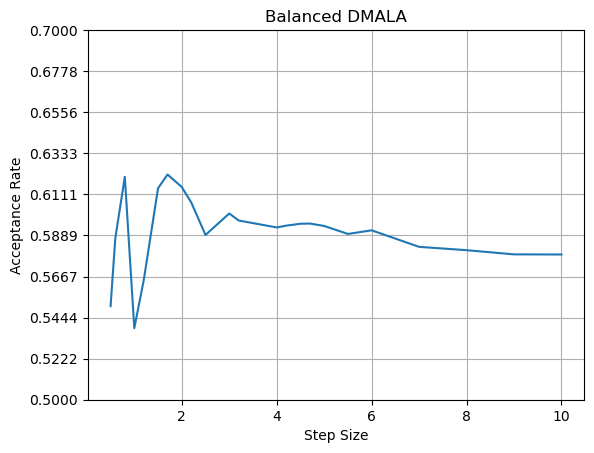

In [119]:
plt.plot(step_sizes_small + step_sizes_big, best_acc_small + best_acc_big)
plt.yticks(np.linspace(.5, .7, 10))
plt.xlabel("Step Size")
plt.ylabel("Acceptance Rate")
plt.title("Balanced DMALA")
plt.grid()

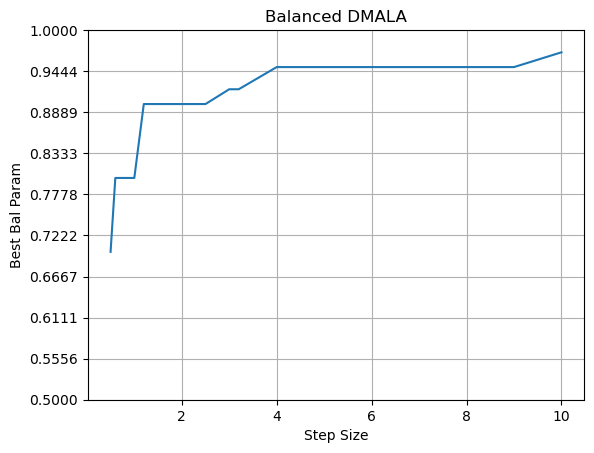

In [120]:
plt.plot(step_sizes_small + step_sizes_big, best_bal_small + best_bal_big)
plt.yticks(np.linspace(.5, 1.0, 10))
plt.xlabel("Step Size")
plt.ylabel("Best Bal Param")
plt.title("Balanced DMALA")
plt.grid()

In [121]:
def calc_stepsizes(init_stepsize, total_iter):
    res = []
    for k_iter in range(total_iter):
        inner = (np.pi * k_iter)/total_iter
        cur_step_size = init_stepsize * (np.cos(inner) + 1)
        step_size = cur_step_size
        res.append(step_size)
    return np.array(res)

def calc_balancing_constants(init_bal, total_iter):
    res = []
    for k_iter in range(total_iter):
        inner = (np.pi * k_iter) / total_iter
        cur_balancing_constant = (init_bal - .5) / 2 * (np.cos(inner)) + (
                    init_bal + .5) / 2
        res.append(cur_balancing_constant)
    return np.array(res)

In [163]:
bals_total = best_bal_small + best_bal_big + [.5]
steps_total = step_sizes_small + step_sizes_big + [.2]
opt_bal = []
for i in range(20):
    cur_step = steps[i]
    closest_rec = np.argmin([abs(s - cur_step) for s in steps_total])
    opt_bal.append(bals_total[closest_rec])

Text(0.5, 0.98, 'Step Size and Bal Param v iteration')

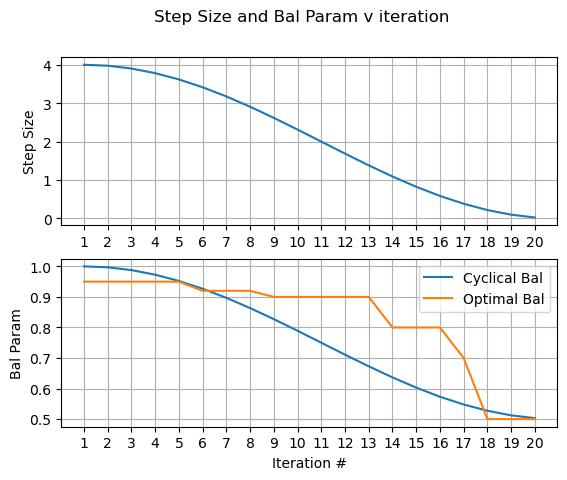

In [167]:
steps = calc_stepsizes(2.0, 20)
b = calc_balancing_constants(1.0, 20)
fig, ax = plt.subplots(2)
x = [i+1 for i in range(20)]
ax[0].plot(x, steps)
ax[0].set_xticks(x)
ax[0].set_ylabel("Step Size")
ax[1].plot(x, b, label="Cyclical Bal")
ax[1].plot(x, opt_bal, label="Optimal Bal")
ax[1].legend()
ax[1].set_xticks(x)
ax[1].set_ylabel("Bal Param")
ax[1].set_xlabel("Iteration #")
ax[0].grid(), ax[1].grid()
plt.suptitle("Step Size and Bal Param v iteration")

In [159]:
bals_total = best_bal_small + best_bal_big + [.5]
steps_total = step_sizes_small + step_sizes_big + [.2]

for i in range(len(steps_total)):
    print(f"bal: {bals_total[i]}, step: {steps_total[i]}")

bal: 0.7, step: 0.5
bal: 0.8, step: 0.6
bal: 0.8, step: 0.8
bal: 0.8, step: 1.0
bal: 0.9, step: 1.2
bal: 0.9, step: 1.5
bal: 0.9, step: 1.7
bal: 0.9, step: 2.0
bal: 0.9, step: 2.2
bal: 0.9, step: 2.5
bal: 0.92, step: 3.0
bal: 0.92, step: 3.2
bal: 0.95, step: 4.0
bal: 0.95, step: 4.2
bal: 0.95, step: 4.5
bal: 0.95, step: 4.7
bal: 0.95, step: 5.0
bal: 0.95, step: 5.5
bal: 0.95, step: 6.0
bal: 0.95, step: 7.0
bal: 0.95, step: 8.0
bal: 0.95, step: 9.0
bal: 0.97, step: 10.0
bal: 0.5, step: 0.2


In [160]:
opt_bal = []
for i in range(20):
    cur_step = steps[i]
    closest_rec = np.argmin([abs(s - cur_step) for s in steps_total])
    opt_bal.append(bals_total[closest_rec])

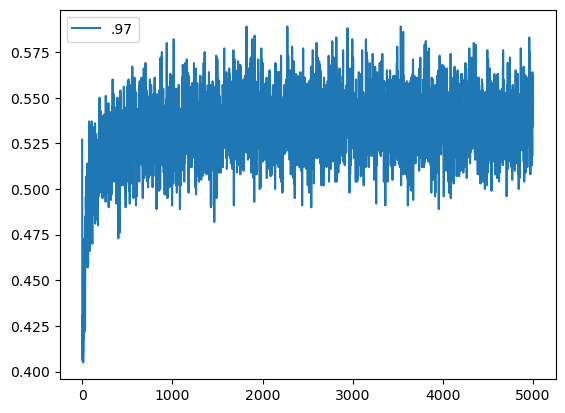

In [301]:
# looking at averages over multiple seeds 
get_mmds_mean = lambda step, bal : np.load(
    f"figs/rbm_sample/num_seeds_10/dmala_stepsize_{step}_{bal}_log_mmds_mean.npy")

get_mmds_var = lambda step, bal : np.load(
    f"figs/rbm_sample/num_seeds_10/dmala_stepsize_{step}_{bal}_log_mmds_var.npy")

get_a_s_mean =  lambda step, bal : np.load(
    f"figs/rbm_sample/num_seeds_10/dmala_stepsize_{step}_{bal}_a_s_mean.npy")
get_a_s_var =  lambda step, bal : np.load(
    f"figs/rbm_sample/num_seeds_10/dmala_stepsize_{step}_{bal}_a_s_var.npy")

#plt.plot(get_mmds_mean(3.2, 0.97))
# plt.plot(get_mmds_var(3.2, 0.97) ** .5)
plt.plot(get_a_s_mean(8.0, 0.92), label=".97")
# plt.plot(get_a_s_mean(8.0, 0.9), label="1.0")
plt.legend()



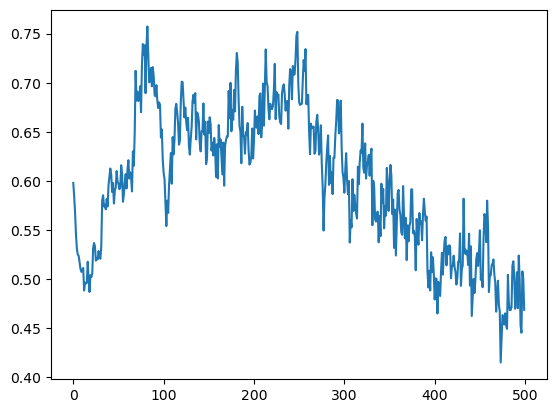

In [270]:
plt.plot(np.load("figs/rbm_sample/num_seeds_10/dmala_use_big_log_mmds_var.npy") ** .5)

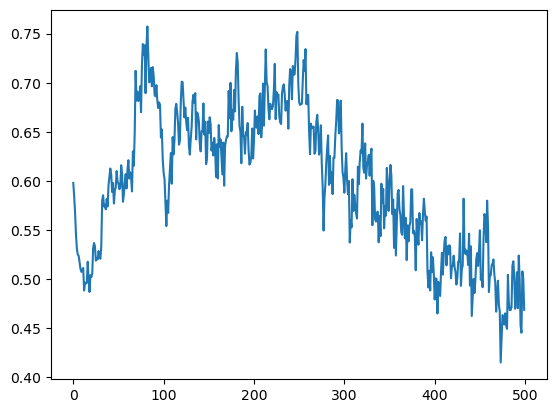

In [275]:
plt.plot(np.load("figs/rbm_sample/num_seeds_10/dmala_u.npy") ** .5)

In [ ]:
plt.plot()